In [1]:
import random

from finrl.meta.env_portfolio_allocation import env_portfolio
import pandas as pd
import numpy as np
import gym
from typing import Callable, Tuple
from collections import defaultdict
from tqdm import trange


In [2]:
def generate_episode(env: gym.Env, policy: Callable, es: bool = False):
    """A function to generate one episode and collect the sequence of (s, a, r) tuples

    This function will be useful for implementing the MC methods

    Args:
        env (gym.Env): a Gym API compatible environment
        policy (Callable): A function that represents the policy.
        es (bool): Whether to use exploring starts or not
    """
    episode = []
    state = env.reset()
    while True:
        if es and len(episode) == 0:
            action = env.action_space.sample()
        else:
            action = policy(state)

        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        if done:
            break
        state = next_state

    return episode


In [3]:
############STUFF GRABBED FROM FINRL TUTORIAL
import matplotlib
import matplotlib.pyplot as plt

matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys

## 2.4. Create Folders
import os

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

print(config_tickers.DOW_30_TICKER)
#dp = YahooFinanceProcessor()
#df = dp.download_data

df = YahooDownloader(start_date='2008-01-01',
                     end_date='2021-10-31',
                     ticker_list=config_tickers.DOW_30_TICKER).fetch_data()

df.head()
df.shape


C:\Users\wacho\Programming\RL_Finance\venv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

(101615, 8)

In [4]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    use_turbulence=False,
    user_defined_feature=False)

df = fe.preprocess_data(df)
df.shape
df.head()

Successfully added technical indicators


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2008-01-02,7.116786,7.152143,6.876786,5.898639,1079178800,AAPL,2,0.0,5.903859,5.896146,100.0,-66.666667,100.0,5.898639,5.898639
3483,2008-01-02,46.599998,47.040001,46.259998,34.026871,7934400,AMGN,2,0.0,5.903859,5.896146,100.0,-66.666667,100.0,34.026871,34.026871
6966,2008-01-02,52.090000,52.320000,50.790001,39.587994,8053700,AXP,2,0.0,5.903859,5.896146,100.0,-66.666667,100.0,39.587994,39.587994
10449,2008-01-02,87.570000,87.839996,86.000000,63.481594,4303000,BA,2,0.0,5.903859,5.896146,100.0,-66.666667,100.0,63.481594,63.481594
13932,2008-01-02,72.559998,72.669998,70.050003,45.605484,6337800,CAT,2,0.0,5.903859,5.896146,100.0,-66.666667,100.0,45.605484,45.605484


In [5]:
df.tail()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
83591,2021-10-29,162.130005,162.440002,160.660004,153.936371,1314100,TRV,4,1.424915,156.635660,144.752571,55.691958,130.838115,19.622993,149.630907,150.155363
87074,2021-10-29,454.410004,461.390015,453.059998,447.971069,2497800,UNH,4,12.812439,459.914485,366.732085,67.009690,145.348191,52.064871,406.440814,405.562350
90557,2021-10-29,52.500000,53.049999,52.410000,46.802307,17763200,VZ,4,-0.170569,48.086328,45.189775,46.685006,-39.966409,12.569826,46.875141,47.474614
94040,2021-10-29,46.860001,47.279999,46.770000,42.506401,4999000,WBA,4,-0.173835,45.248869,41.483368,45.913424,-97.341088,0.268701,43.394445,43.904503
97523,2021-10-29,147.910004,150.100006,147.559998,144.852417,7340900,WMT,4,1.795642,147.887255,129.205267,59.710691,130.750304,35.423702,138.057022,140.642311


In [6]:

## Add covariance matrix as states
# add covariance matrix as states
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i - lookback:i, :]
    price_lookback = data_lookback.pivot_table(index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)

df_cov = pd.DataFrame({'date': df.date.unique()[lookback:], 'cov_list': cov_list, 'return_list': return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)

df.shape
df.head()


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,2.583909,607541200,AAPL,2,-0.082603,3.093651,2.454292,42.254773,-80.462582,16.129793,2.749560,2.861671,"[[0.0013489683474773992, 0.0004284121577427252...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,42.168476,6287200,AMGN,2,0.157987,43.042823,41.174410,51.060584,51.533027,10.432018,41.380861,40.923031,"[[0.0013489683474773992, 0.0004284121577427252...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,14.580748,9625600,AXP,2,-0.935583,18.646870,12.660472,42.554845,-75.437701,25.776759,15.744064,17.616374,"[[0.0013489683474773992, 0.0004284121577427252...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,32.005886,5443100,BA,2,-0.279801,32.174382,28.867833,47.440230,156.994632,5.366299,30.327212,32.389914,"[[0.0013489683474773992, 0.0004284121577427252...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,29.608643,6277400,CAT,2,0.655610,30.348082,25.455649,51.205290,98.374086,26.331746,26.689548,26.423591,"[[0.0013489683474773992, 0.0004284121577427252...",tic AAPL AMGN AXP ...


In [7]:
## Training data split: 2009-01-01 to 2020-07-01
train = data_split(df, '2009-01-01', '2020-07-01')
#trade = data_split(df, '2020-01-01', config.END_DATE)
train.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2009-01-02,3.067143,3.251429,3.041429,2.747391,746015200,AAPL,4,-0.070153,3.080129,2.452223,45.440203,-32.212819,2.140064,2.750408,2.862473,"[[0.0013661501126321339, 0.0004339378272971406...",tic AAPL AMGN AXP ...
0,2009-01-02,58.590000,59.080002,57.750000,43.073925,6547900,AMGN,4,0.233986,43.189560,41.138661,52.756854,92.867180,0.814217,41.445361,41.011871,"[[0.0013661501126321339, 0.0004339378272971406...",tic AAPL AMGN AXP ...
0,2009-01-02,18.570000,19.520000,18.400000,15.193850,10955700,AXP,4,-0.832049,18.463256,12.644437,43.957559,-42.853033,16.335101,15.742754,17.499519,"[[0.0013661501126321339, 0.0004339378272971406...",tic AAPL AMGN AXP ...
0,2009-01-02,42.799999,45.560001,42.779999,33.941086,7010200,BA,4,-0.002010,32.948622,28.452129,50.822022,272.812515,20.494464,30.469477,32.344130,"[[0.0013661501126321339, 0.0004339378272971406...",tic AAPL AMGN AXP ...
0,2009-01-02,44.910000,46.980000,44.709999,31.093397,7117200,CAT,4,0.833182,30.850182,25.434765,53.661255,129.524719,34.637448,26.926400,26.424172,"[[0.0013661501126321339, 0.0004339378272971406...",tic AAPL AMGN AXP ...


In [8]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)
e_train_gym_two = StockPortfolioEnv(df = train, **env_kwargs)
e_train_gym_three = StockPortfolioEnv(df = train, **env_kwargs)


Stock Dimension: 28, State Space: 28


(28, 18)
AAPL
[28.322500228881836]
AMGN
[142.9199981689453]
AXP
[74.69999694824219]
BA
[156.0]
CAT
[96.01000213623047]
CRM
[70.81999969482422]
CSCO
[30.079999923706055]
CVX
[117.7699966430664]
DIS
[104.61000061035156]
GS
[240.5]
HD
[133.1300048828125]
HON
[111.5634994506836]
IBM
[159.3881378173828]
INTC
[35.779998779296875]
JNJ
[112.69000244140625]
JPM
[85.36000061035156]
KO
[42.0]
MCD
[121.56999969482422]
MMM
[178.25]
MRK
[58.625953674316406]
MSFT
[61.81999969482422]
NKE
[51.5]
PG
[84.20999908447266]
TRV
[119.87000274658203]
UNH
[158.8300018310547]
VZ
[51.540000915527344]
WBA
[85.87999725341797]
WMT
[70.06999969482422]


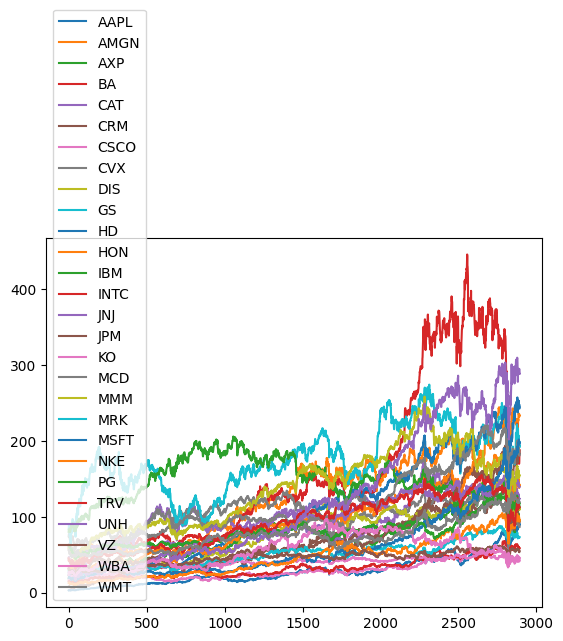

In [41]:
print(e_train_gym_three.data.shape)
for ticker in e_train_gym_three.data['tic'].unique():
    print(ticker)
    
    print(e_train_gym_three.data[e_train_gym_three.data['tic'] == ticker]['open'].tolist())
    plt.plot(e_train_gym_three.df[e_train_gym_three.df['tic'] == ticker]['open'].tolist(), label=ticker)
plt.legend(loc='lower left')

In [13]:
import random
def random_agent(env: StockPortfolioEnv, iter=2000):
    env.reset()
    for iteration in range(iter):
        action = [0] * len(env.action_space.sample())
        action[random.randint(0,  len(env.action_space.sample()) - 1)] = 1
        state, reward, terminal, _, _ = env.step(action)
    return env

def argmax_explore_agent(env: StockPortfolioEnv, iter=2000):
    env.reset()
    
    taken_actions = defaultdict(list)
    for iteration in range(int(iter/2)):
        action = env.action_space.sample()
        state, reward, terminal, _, _ = env.step(action)
        action = tuple(action)
        taken_actions[action] = taken_actions[action] + [reward]
    avgs = [np.mean(rewards) for rewards in taken_actions.values()]
    action = list(taken_actions.keys())[np.argmax(avgs)]
    for iteration in range(int(iter/2)):
        state, reward, terminal, _, _ = env.step(action)
        taken_actions[action] = taken_actions[action] + [reward]
    return env

def argmin_explore_agent(env: StockPortfolioEnv, iter=2000):
    env.reset()
    
    taken_actions = defaultdict(list)
    for iteration in range(int(iter/2)):
        action = env.action_space.sample()
        state, reward, terminal, _, _ = env.step(action)
        action = tuple(action)
        taken_actions[action] = taken_actions[action] + [reward]
    avgs = [np.mean(rewards) for rewards in taken_actions.values()]
    action = list(taken_actions.keys())[np.argmin(avgs)]
    for iteration in range(int(iter/2)):
        state, reward, terminal, _, _ = env.step(action)
        taken_actions[action] = taken_actions[action] + [reward]
    return env
    

In [17]:
env_after_training = random_agent(e_train_gym)
other_agent_env = argmax_explore_agent(e_train_gym_two)
more_env = argmin_explore_agent(e_train_gym_three)


[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (2893, 8)


<Axes: >

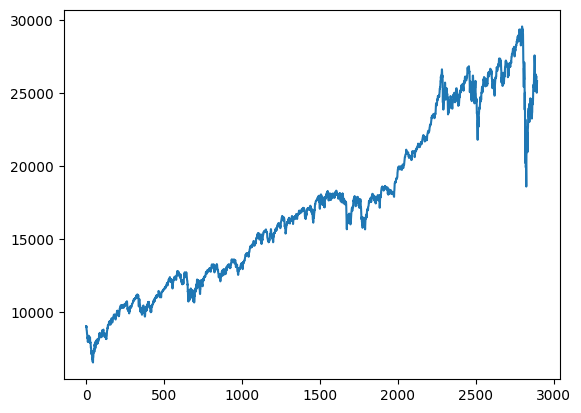

In [18]:

from finrl.plot import get_baseline
baseline_df = get_baseline(ticker="^DJI",
                          start= '2009-01-01', end='2020-07-01')
baseline_df['close'].plot()

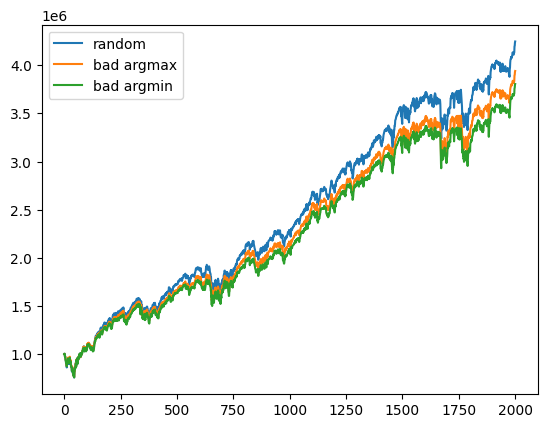

In [19]:
plt.plot(list(range(len(env_after_training.portfolio_return_memory

))), env_after_training.asset_memory, label="random"
)
plt.plot(list(range(len(other_agent_env.portfolio_return_memory

))), other_agent_env.asset_memory, label="bad argmax"

)
plt.plot(list(range(len(more_env.portfolio_return_memory

))), more_env.asset_memory, label="bad argmin"

)
plt.legend()